In [1]:
from tqdm import tqdm
import numpy as np
from pickle import load

def read_matrix_pickle():
    # 0:14 -- float64
    # 0:02 -- float32
    with open("../datasets/model.pickle", "rb") as f:
        mat = load(f)
        words = load(f)
    return mat, words

In [18]:
def read_tweet(f_desc):
    ans = dict()
    ans['username'] = f_desc.readline()
    ans['tweet_id'] = f_desc.readline()
    ans['time'] = f_desc.readline()
    ans['user_app'] = f_desc.readline()
    ans['retweet_from'] = f_desc.readline()
    ans['reply_to'] = f_desc.readline()
    ans['content'] = list(map(int, f_desc.readline().split()))
    n_links = int(f_desc.readline())
    for i in range(n_links):
        f_desc.readline()
    f_desc.readline() # нужно ли?
    return ans


def read_tweets(path='../datasets/tweet_result_0_.txt'):
    f_desc = open(path)
    ans = []
    for i in range(200):
        ans.append(read_tweet(f_desc))
    return ans

some_tweets = read_tweets()

In [21]:
def read_cnt(path='../datasets/twitter_dataset/WordTable.txt'):
    ans = []
    f_desc = open(path)
    n_words = int(f_desc.readline())
    for line in tqdm(f_desc, total=n_words):
        code, cnt, word = line.split('\t')
        ans.append(int(cnt))
    return ans

cnt = read_cnt()

100%|██████████| 8177599/8177599 [00:27<00:00, 300849.94it/s]


(array([7465688.,  252797.,  103864.,   59018.,   35761.,   29270.,
          21897.,   17412.,   14020.,   11791.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

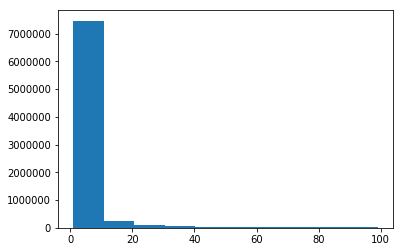

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([i for i in cnt if i < 100])

In [19]:
def read_word_dict(path='../datasets/twitter_dataset/WordTable.txt'):
    ans = dict()
    f_desc = open(path)
    n_words = int(f_desc.readline())
    for line in tqdm(f_desc, total=n_words):
        code, cnt, word = line.split('\t')
        if int(cnt) > 10:
            ans[int(code)] = word
    return ans

word_dict = read_word_dict()

100%|██████████| 8177599/8177599 [00:29<00:00, 280783.38it/s]


In [20]:
def get_words(content):
    ans = ""
    for i in content:
        try:
            ans += " " + word_dict[i][:-1]
        except: pass
    return ans

for tw in some_tweets:
    print(get_words(tw['content']))

 yo luci thing miami kinda cold beauti love
 happi day luci
 im wait
 beauti brotherhood
 smiley
 friend ground ve cough week nice summer holiday
 great haha
 im ive year fuck wbu luci

 south america love
 joe jona bcs parti cute
 miss luci
 wow tt today epic
 ikr im wednesday haha
 wait avatar
 aaah memee gw lagi paniiik taauu sok panik
 deb itu gr2 td aq cabut paksa gr2 lmot stlh pasang ut jd restart lg ni
 kacaau da yg tau ga gmn balikin isi memorycard masaak foto dn lagu di mmc saya hilang semua
 baah hahaa
 hahaha knp jadi dijual semua hp nya nen si udah ganti hape jg
 udaaah heeey dari kapan tauu
 punten sadayana numpang lewat rt asikk dibayarin hari kami kita mo ditraktir makan2
 hahaha maaf rt keterbatasan komunikasi 140 antara indomi vegan taro rumput laut hahaha
 winaa itu enak taro rt jangan bayangin taro rasa rumput rasanya persi kayak sawi yg di mie
 rt kompa karier fair 2010 bukan hanya cari kerja
 ngetik keyword roti yg keluar malah pijat eroti
 kesimpulan hari ini adal

In [6]:
some_tweets[5]

{'content': [1625760,
  5553222,
  2500655,
  15207713,
  5955763,
  8389847,
  18240579,
  20504244],
 'reply_to': '-1\n',
 'retweet_from': '-1\n',
 'time': 'Mon Feb 01 23:55:42 +0000 2010\n',
 'tweet_id': '8519608343\n',
 'user_app': 'via web\n',
 'username': 'Joes_face\n'}

In [ ]:
%%time

mat, words = read_matrix_pickle()
del mat

In [ ]:
len(words)

In [ ]:
words[0]

In [ ]:
sizes = [len(i.split('_')) for i in words]

In [ ]:
set(sizes)

In [ ]:
words_1 = [i.split('_')[0] for i in words]

In [ ]:
len(words_1)

In [ ]:
!ls ../datasets/twitter_dataset/